# 프로야구 선수의 다음 해 연봉 예측하기
- 회귀 분석 : 독립변수(X)와 종속변수(Y) 간의 관계를 찾아내는 것
- 방정식의 계수 w와 b를 잘 정하는 것
## step 1 탐색 : 프로 야구 연봉 데이터 살펴보기

In [34]:
# 프로야구 연봉 데이터셋의 기본 정보 구하기
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

picher_file_path = '../data/picher_stats_2017.csv'
batter_file_path = '../data/batter_stats_2017.csv'
picher = pd.read_csv(picher_file_path)
batter = pd.read_csv(batter_file_path)

picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [35]:
picher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [36]:
print(picher.shape)

(152, 22)


In [37]:
picher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

In [38]:
# 한글 폰트 적용
import matplotlib as mpl
mpl.rc("font", family="NanumGothic")

<AxesSubplot:>

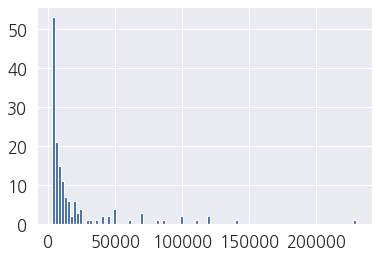

In [39]:
# 2018년 연봉 분포를 출력
picher['연봉(2018)'].hist(bins=100) 

<AxesSubplot:>

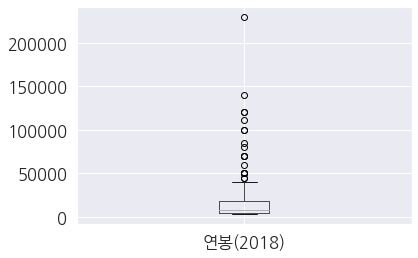

In [40]:
# 연봉의 상자 그림을 출력
picher.boxplot(column=['연봉(2018)'])

- '선수명', '팀명'과 같이 그래프로 표현할 수 없는 피처들을 제외
- 모든 수치형 피처의 분포를 시각화

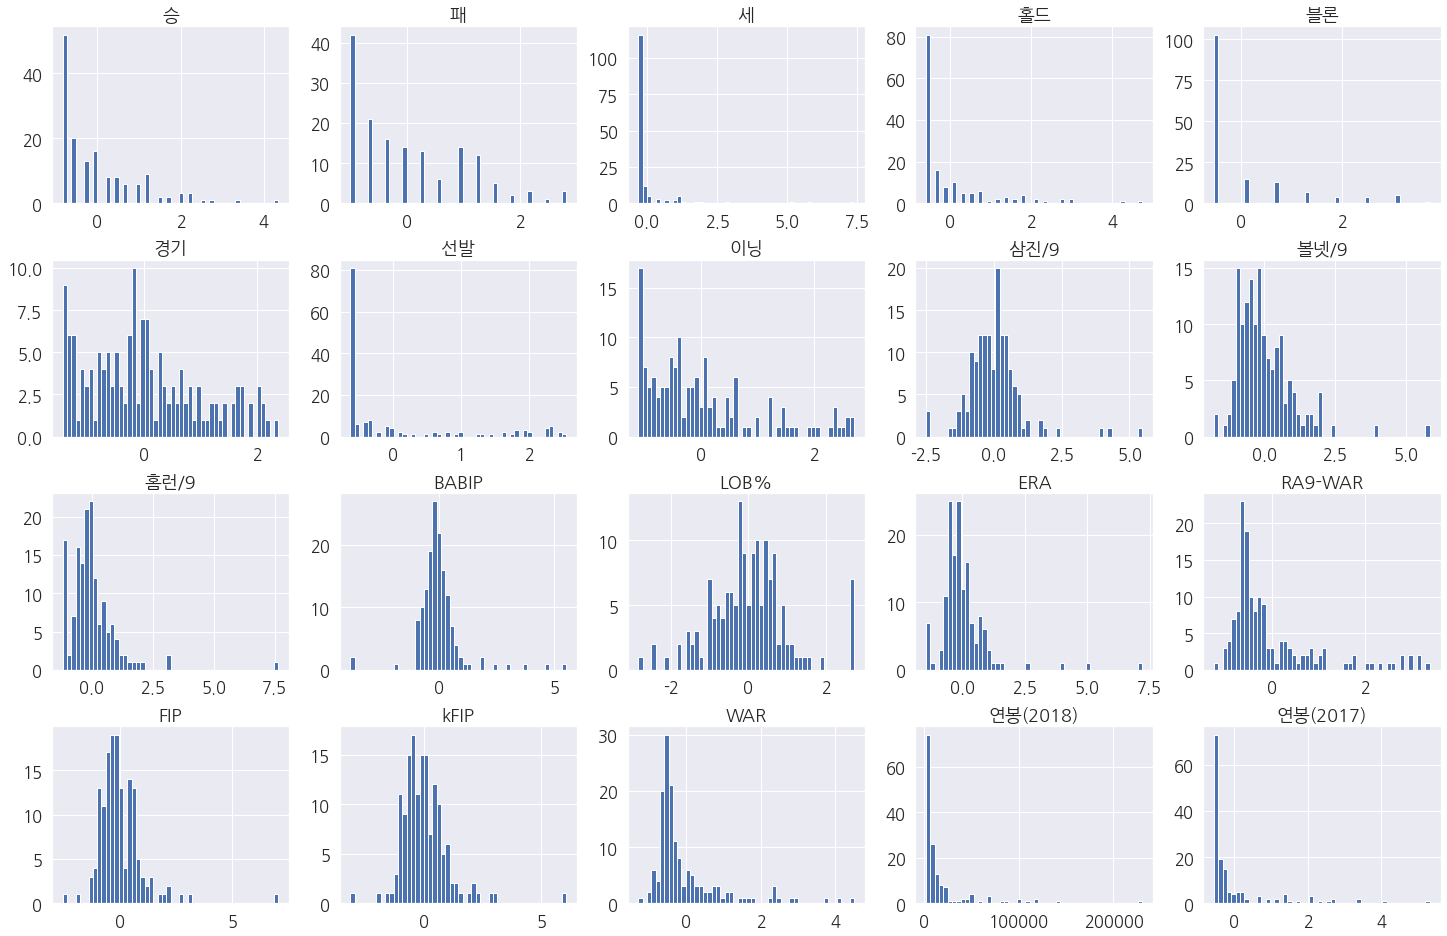

In [58]:
# 회귀 분석에 사용할 피처 살펴보기
picher_features_df = picher[['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)']]

# 피처 각각에 대한 histogram을 출력합니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.tight_layout() # 겹치지 않게 여백 주기
    plt.show()

plot_hist_each_column(picher_features_df)

- 각 피처 간의 단위가 다름 => 피처의 정규화 혹은 스케일링이 되어있지 않은 데이터


피처의 정규화(피처 스케일링)
- 피처들의 단위를 0~1 사이, 혹은 상대적 값을 표현할 수 있는 수치로 맞춰주는 것


## step 2 예측 : 투수의 연봉 예측하기
z-값 = ((X) - (X의 평균)) / X의 표준편차

In [42]:
# 피처들의 단위 맞춰주기 : 피처 스케일링
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

# 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2017)']
picher_df = standard_scaling(picher, scale_columns)

picher_df = picher_df.rename(columns={'연봉(2018)': 'y'})
picher_df.head(5)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


범주형 피처에는 **원-핫 인코딩** 방법 적용
판다스의 get_dummies() 함수로 원-핫 인코딩 적용 가능

In [43]:
# 팀명 피처를 one-hot encoding으로 변환합니다.
team_encoding = pd.get_dummies(picher_df['팀명'])
picher_df = picher_df.drop('팀명', axis=1)
picher_df = picher_df.join(team_encoding)

In [44]:
team_encoding.head(5)

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


모델의 학습 데이터셋(학습 전용 데이터셋)과 모델의 테스트 데이터셋(테스트 전용 데이터셋)으로 데이터를 분리
- sklearn 모듈의 train_test_split()함수로 수행 가능
- (X_train, y_train):(X_test, y_test) = 8:2 비율로 총 4개의 데이터 생성
- X_train, y_train은 학습 데이터셋, X_test, y_test는 테스트 데이터셋

In [45]:
# ! pip install sklearn

In [46]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리합니다.
X = picher_df[picher_df.columns.difference(['선수명', 'y'])] # '선수명', 'y' 제외하고 선택
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19) # random_state: 분할시 셔플이 이루어지는데 이를 위한 시드 값

In [47]:
# 회귀 분석 계수를 학습합니다 (회귀 모델 학습)
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# 학습된 계수를 출력합니다.
print(lr.coef_)

[ -1481.01733901   -416.68736601 -94136.23649209  -1560.86205158
   1572.00472193   -747.04952389  -1375.53830289   -523.54687556
   3959.10653661    898.37638984  10272.48746451  77672.53804469
  -2434.38947427   -892.11801281    449.91117164   7612.15661812
   1271.04500059  -2810.5564514    5396.97279896  -4797.30275904
   -250.69773139    236.02530053  19130.59021357    854.02604585
   1301.61974637   3613.84063182   -935.07281796  18144.60099745]


## step 3 평가 : 예측 모델 평가하기
회귀 분석은 statsmodel 라이브러리의 OLS 클래스로도 실행 가능  
OLS 클래스의 summary() 함수를 사용하면 다음의 실행 결과처럼 계수에 대한 자세한 분석 내용을 볼 수 있음

In [15]:
! pip install statsmodels

In [48]:
# 어떤 피처가 가장 영향력이 강한 피처일까
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행합니다.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.19
Date:                Fri, 08 Apr 2022   Prob (F-statistic):           7.70e-42
Time:                        20:28:16   Log-Likelihood:                -1247.8
No. Observations:                 121   AIC:                             2552.
Df Residuals:                      93   BIC:                             2630.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BABIP      -1481.0173   1293.397     -1.145      0.255   -4049.448    1087.414
ERA         -416.6874   2322.402     -0.179      0.858   -5028.517    4195.143
FIP        -9.414e+04   9.43e+04     -0.998      0.321   -2.81e+05    9.31e+04
KIA         1.708e+04   2332.163      7.324      0.000    1.24e+04    2.17e+04
KT          2.021e+04   2208.542      9.152      0.000    1.58e+04    2.46e+04
LG          1.789e+04   2508.189      7.134      0.000    1.29e+04    2.29e+04
LOB%       -1375.5383   1564.806     -0.879      0.382   -4482.933    1731.857
NC          1.812e+04   2822.991      6.418      0.000    1.25e+04    2.37e+04
RA9-WAR     3959.1065   2931.488      1.351      0.180   -1862.247    9780.460
SK          1.954e+04   2337.570      8.359      0.000    1.49e+04    2.42e+04
WAR         1.027e+04   2532.309      4.057      0.000    5243.823    1.53e+04
kFIP        7.767e+04   7.95e+04      0.977      0.331   -8.03e+04    2.36e+05
경기         -2434.3895   2953.530     -0.824      0.412   -8299.515    3430.736
두산          1.775e+04   2754.746      6.443      0.000    1.23e+04    2.32e+04
롯데          1.909e+04   2691.571      7.093      0.000    1.37e+04    2.44e+04
볼넷/9        7612.1566   6275.338      1.213      0.228   -4849.421    2.01e+04
블론          1271.0450   1242.128      1.023      0.309   -1195.576    3737.666
삼성          1.583e+04   2613.810      6.056      0.000    1.06e+04     2.1e+04
삼진/9        5396.9728   7286.221      0.741      0.461   -9072.019    1.99e+04
선발         -4797.3028   5489.352     -0.874      0.384   -1.57e+04    6103.463
세           -250.6977   1295.377     -0.194      0.847   -2823.059    2321.663
승            236.0253   2215.264      0.107      0.915   -4163.049    4635.100
연봉(2017)    1.913e+04   1270.754     15.055      0.000    1.66e+04    2.17e+04
이닝           854.0260   6623.940      0.129      0.898   -1.23e+04     1.4e+04
패           1301.6197   1935.935      0.672      0.503   -2542.763    5146.003
한화          2.225e+04   2292.308      9.708      0.000    1.77e+04    2.68e+04
홀드          -935.0728   1637.923     -0.571      0.569   -4187.663    2317.518
홈런/9        1.814e+04   1.68e+04      1.082      0.282   -1.52e+04    5.14e+04
==============================================================================
Omnibus:                       28.069   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.274
Skew:                          -0.405   Prob(JB):                     6.52e-43
Kurtosis:                       9.155   Cond. No.                         423.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 결정 계수(R-squared), 혹은 수정 결정 계수(Adj.R-squared)는 회귀 분석이 얼마나 잘 되었는지 평가하는 지표  
- '회귀 분석으로 추정한 모델이 주어진 데이터를 얼마나 잘 설명하는가?'에 대한 점수  
- 이 점수가 1에 가까울수록 데이터를 잘 설명하는 모델

- F 통계량(F-statistic)은 회귀식의 유의성 검정에 사용되는 값
- F 통계량에 대한 p-value인 Prob(F-statistic) 수치와 함께 봐야 한다
- 일반적으로 p-value가 0.05 이하면 'F 통계량이 유의한 의미를 가진다' 라는 결론을 내려도 무방하며 이는 회귀 분석이 유의미한 결과를 가진다는 것
- P > |t|: 각 피처의 검정 통계량 (t-statistics)이 얼마나 유의미한지에 대한 p-value를 나타내는 것('WAR', '연봉(2017)', '한화' 3개 피처의 p-value가 0.05 미만으로 나타났기 때문에 회귀분석에서 유의미한 피처들이라는 결론 내릴 수 있음)


학습한 coef(계수) 값들을 시각화

[Text(0, 0, 'const'),
 Text(1, 0, 'BABIP'),
 Text(2, 0, 'ERA'),
 Text(3, 0, 'FIP'),
 Text(4, 0, 'KIA'),
 Text(5, 0, 'KT'),
 Text(6, 0, 'LG'),
 Text(7, 0, 'LOB%'),
 Text(8, 0, 'NC'),
 Text(9, 0, 'RA9-WAR'),
 Text(10, 0, 'SK'),
 Text(11, 0, 'WAR'),
 Text(12, 0, 'kFIP'),
 Text(13, 0, '경기'),
 Text(14, 0, '두산'),
 Text(15, 0, '롯데'),
 Text(16, 0, '볼넷/9'),
 Text(17, 0, '블론'),
 Text(18, 0, '삼성'),
 Text(19, 0, '삼진/9'),
 Text(20, 0, '선발'),
 Text(21, 0, '세'),
 Text(22, 0, '승'),
 Text(23, 0, '연봉(2017)'),
 Text(24, 0, '이닝'),
 Text(25, 0, '패'),
 Text(26, 0, '한화'),
 Text(27, 0, '홀드'),
 Text(28, 0, '홈런/9')]

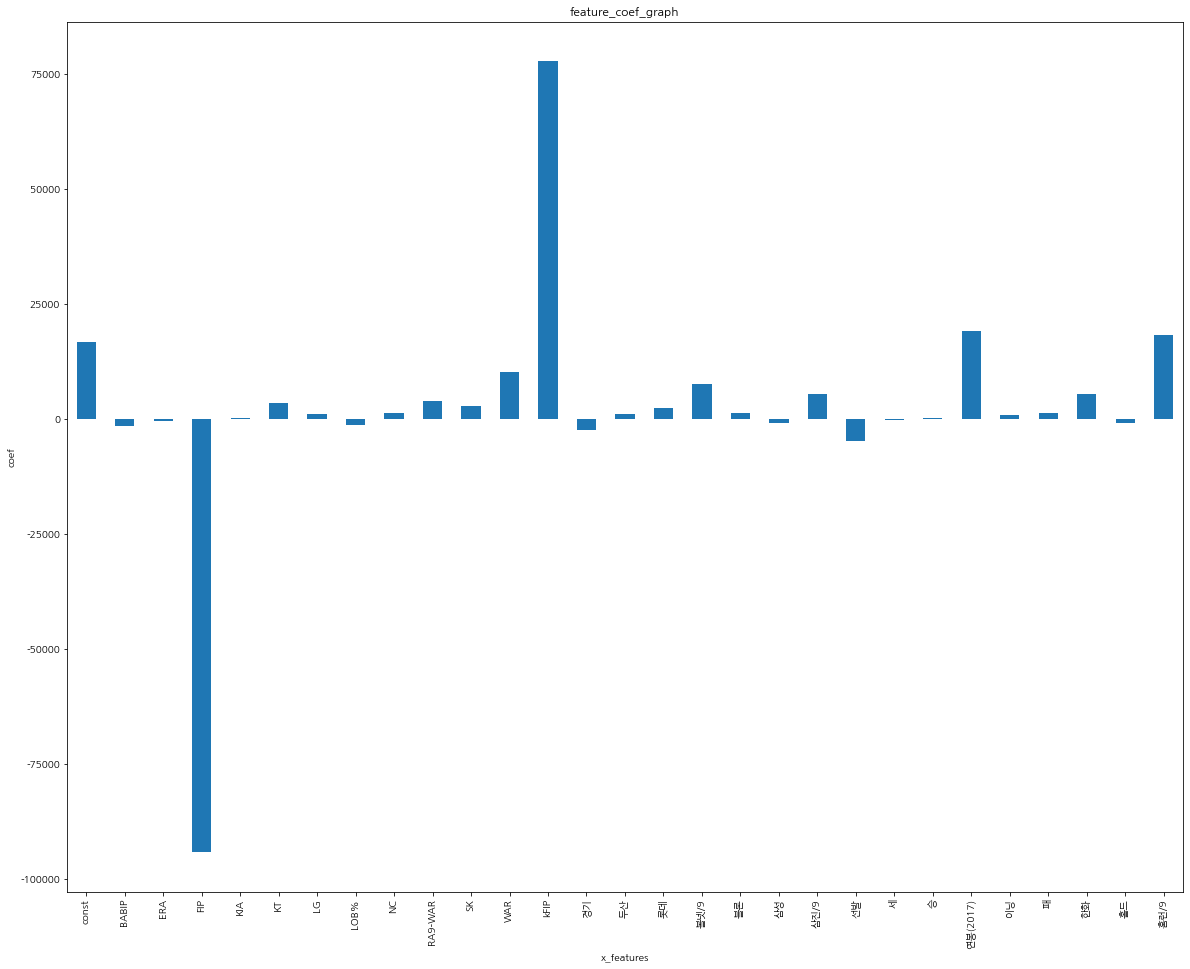

In [17]:
# 어떤 피처가 가장 영향력이 강한 피처일까

# 한글 출력을 위한 사전 설정 단계입니다.
mpl.rc('font', family='NanumGothic')
plt.rcParams['figure.figsize'] = [20, 16]

# 그래프에서 마이너스 부호 나오게
mpl.rcParams['axes.unicode_minus'] = False 

# 회귀 계수를 리스트로 반환합니다.
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명을 리스트로 반환합니다.
x_labels = model.params.index.tolist()

# 회귀 계수를 출력합니다.
ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

수정 결정 계수(R2 score)를 sklean의 LinearRegression 클래스로 출력

In [18]:
# 예측 모델의 평가하기 : R2 score
# 학습 데이터와 테스트 데이터로 분리합니다.
X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [19]:
# 회귀 분석 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [20]:
# 회귀 분석 모델을 평가합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.9276949405576705
0.8860171644977818


- 실행 결과의 각 값은 학습 데이터셋과 테스트 데이터셋에 대한 평가 점수 의미
- 이 두 점수는 최대한 벌어지지 않는 것이 좋음
- 만약 학습 점수가 테스트 점수에 비해 높다면 과적합 발생


RMSE score라는 측정 지표 활용할 수 있음
- 이 점수는 실제값과 예측값의 차이를 절대적인 수치로 나타낸것
- 이 값이 높으면 높을수록 예측이 부정확하다는 것을 의미

In [21]:
# 예측 모델의 평가하기 : RMSE score
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

7282.718684746374
14310.696436889131


미니 퀴즈 3-1  
Train score, Test score의 차이점은? 어떤 점수가 더 높아야 할까?
- 훈련 데이터셋은 모델을 학습하는 용도로 사용, 테스트 데이터셋은 결과를 평가하기 위한 용도로만 활용
- Train score, Test score는 이 두 데이터 각각으로만 평가한 점수
- Train score, Test score가 차이가 없는 것이 이상적임




피처들의 상관 관계를 살펴보기 위해 heatmap 방식의 시각화 사용

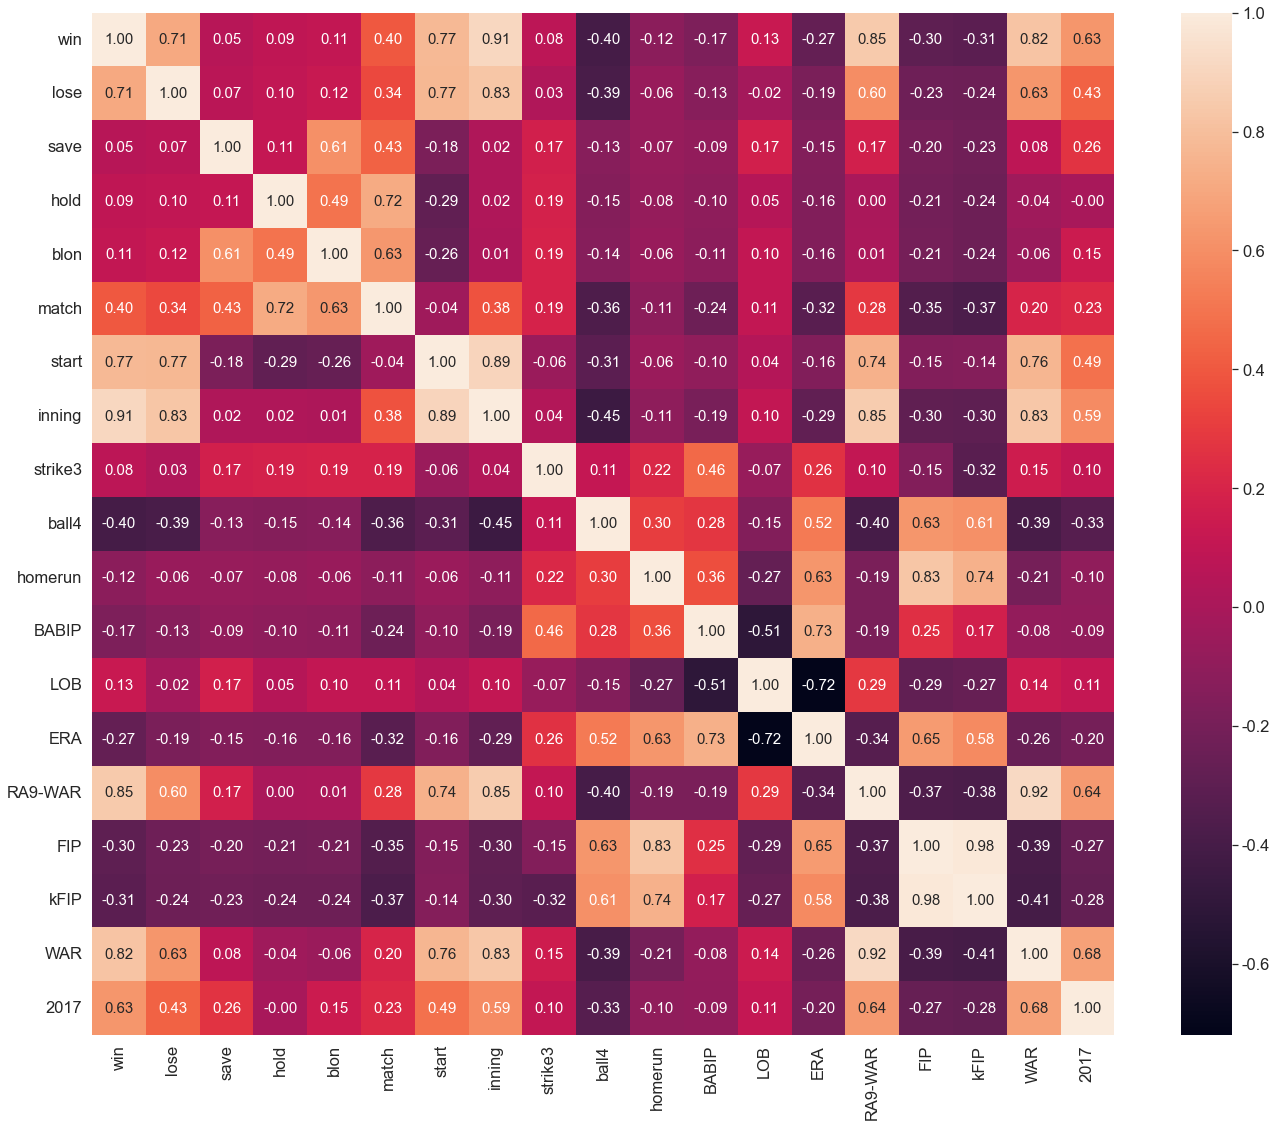

In [22]:
# 피처들의 상관 관계 분석하기

import seaborn as sns

# 피처간의 상관계수 행렬을 계산합니다.
corr = picher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 
             'inning', 'strike3', 'ball4', 'homerun', 'BABIP', 'LOB', 
             'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '2017']

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothic')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

- 회귀 분석은 피처 간의 '독립성'을 전제로 하는 분석 방법이기 때문에 올바른 회귀 분석을 하려면 이러한 피처 쌍을 제거해야함
- **다중 공선성**: 변수 간 상관 관계가 높아 분석에 부정적인 영향을 미치는 것을 의미
- 다중 공선성을 살펴봄으로써 여러 피처 간의 연관성을 고려했을 때 어떤 피처를 제거하는 것이 옳은 판단일지 혹은 제거하는 것 자체가 맞는 판단인지에 대한 기준을 제시해줄 수 있음
- 다중 공선성은 분산팽창요인(VIF)이라는 계수로 평가할 수 있음
    - VIF 계수가 10~15 정도를 넘으면 그 피처는 다중 공선성의 문제가 발생했다고 판단

In [23]:
# 회귀 분석 예측 성능을 높이기 위한 방법 : 다중 공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


미니 퀴즈 3-2

In [24]:
# 피처를 재선정합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [25]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [26]:
# 결과를 출력합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.9150591192570362
0.9038759653889866


In [27]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

7893.462873347693
13141.866063591076


In [28]:
# 피처마다의 VIF 계수를 출력합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,1.9,FIP
1,2.1,WAR
2,1.9,볼넷/9
3,1.1,삼진/9
4,1.9,연봉(2017)


## step 4 시각화 : 분석 결과 시각화하기
회귀 분석을 통해 얻어낸 예측 연봉과 2018년의 실제 연봉 데이터를 비교하는 시각화 자료 만들기  
predict()함수를 사용하여 2018년의 연봉을 예측하고, 이를 원래 데이터 프레임에 '예측연봉'이라는 새로운 열로 합침  

In [29]:
# 예측연봉과 실제연봉 비교하기
# 2018년 연봉을 예측하여 데이터프레임의 column으로 생성합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
predict_2018_salary = lr.predict(X)
picher_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)
picher_df

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화,예측연봉(2018)
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,0,0,0,0,1,0,0,0,0,120122.822204
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,0,0,1,0,0,0,0,0,0,88127.019455
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,1,0,0,0,0,0,0,0,0,163930.148696
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,0,0,1,0,0,0,0,0,0,116009.684582
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,0,0,0,0,0,0,1,0,0,102253.697589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,장민재,-0.309907,0.588357,-0.306452,-0.585705,0.680497,0.214300,-0.112010,0.104300,-0.968896,...,0,0,0,0,0,0,0,0,1,3080.623786
148,정용운,-0.051084,-0.369825,-0.306452,-0.585705,-0.543592,-0.198678,0.503369,0.042667,-0.777918,...,1,0,0,0,0,0,0,0,0,-395.321720
149,노경은,-0.827554,-0.369825,-0.306452,-0.585705,-0.543592,-1.024633,-0.419699,-0.850019,-0.756699,...,0,0,0,0,0,0,1,0,0,8896.091512
150,김승현,-0.827554,-0.050431,-0.306452,-0.364245,-0.543592,0.627278,-0.624825,-0.273451,0.205264,...,0,0,0,0,0,0,0,1,0,-2185.865106


In [30]:
# 원래의 데이터 프레임을 다시 불러옵니다.
picher = pd.read_csv(picher_file_path)
picher = picher[['선수명', '연봉(2017)']]
picher

,선수명,연봉(2017)
0,켈리,85000
1,소사,50000
2,양현종,150000
3,차우찬,100000
4,레일리,85000
...,...,...
147,장민재,8100
148,정용운,3100
149,노경은,16000
150,김승현,2900


In [31]:
# 원래의 데이터 프레임에 2018년 연봉 정보를 합칩니다.
result_df = picher_df.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(picher, on=['선수명'], how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']
result_df

,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,양현종,230000,163930.148696,150000
1,켈리,140000,120122.822204,85000
2,소사,120000,88127.019455,50000
3,정우람,120000,108489.464585,120000
4,레일리,111000,102253.697589,85000
...,...,...,...,...
147,장지훈,2800,249.850641,2700
148,차재용,2800,900.811527,2800
149,성영훈,2700,5003.619609,2700
150,정동윤,2700,2686.350884,2700


In [32]:
# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰합니다.
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,163930.148696,150000
1,1,켈리,140000,120122.822204,85000
2,2,소사,120000,88127.019455,50000
3,4,레일리,111000,102253.697589,85000
4,7,피어밴드,85000,58975.725734,35000
5,13,배영수,50000,56873.662417,55000
6,21,안영명,35000,22420.790838,20000
7,22,채병용,30000,21178.955105,25000
8,23,류제국,29000,45122.360087,35000
9,24,박정진,25000,29060.748299,33000


<AxesSubplot:xlabel='선수명'>

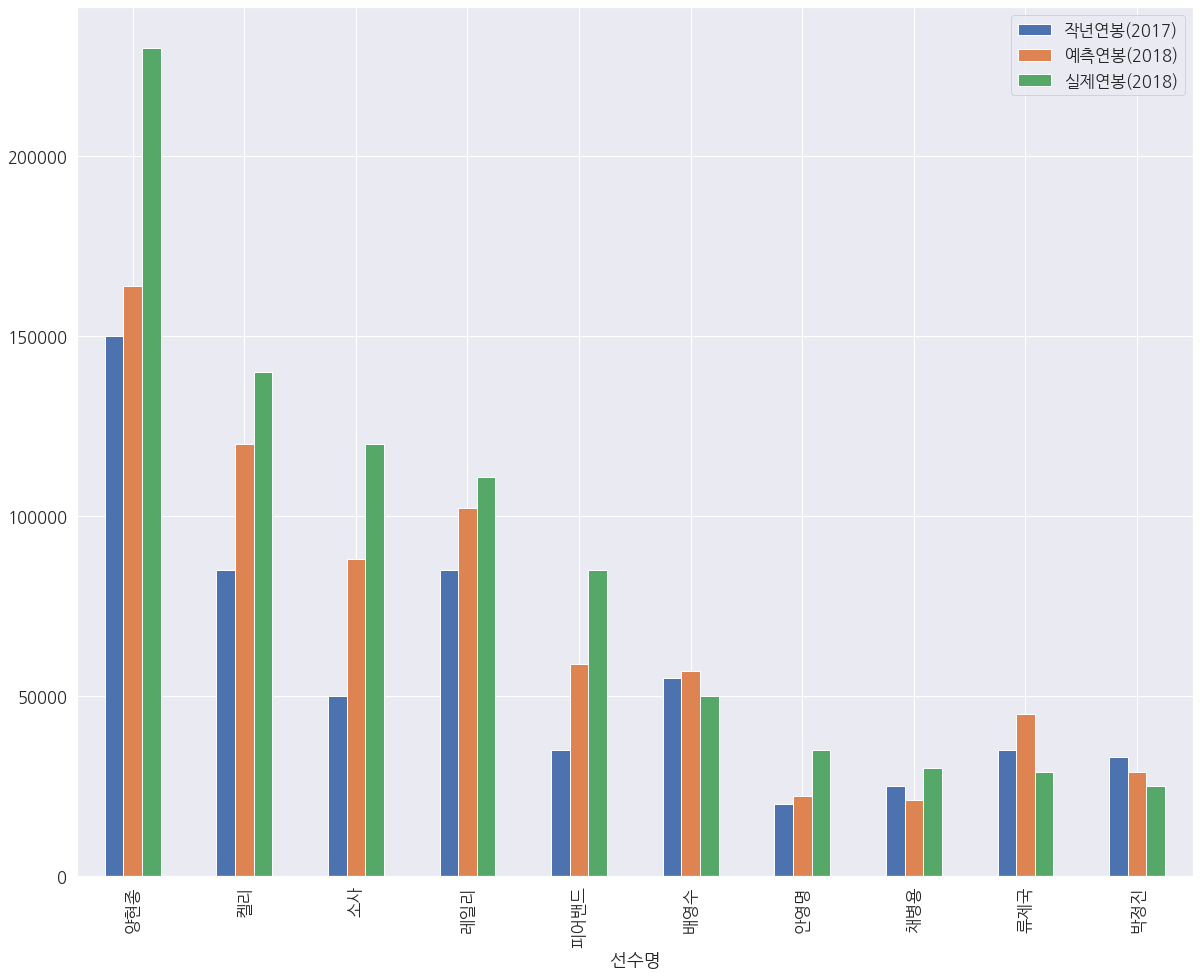

In [33]:
# 선수별 연봉 정보(작년 연봉, 예측 연봉, 실제 연봉)를 bar 그래프로 출력합니다.
mpl.rc('font', family='NanumGothic')
result_df.plot(x='선수명', y=['작년연봉(2017)', '예측연봉(2018)', '실제연봉(2018)'], kind="bar")

# 비트코인 시세 예측하기
- 비트코인 시세처럼 연속적인 시간에 따라 다르게 측정되는 데이터를 **'시계열 데이터'** 라고 하며,  
이를 분석하는 것을 '시계열 데이터 분석'이라고 한다.

## step 1 탐색 : 시간 정보가 포함된 데이터 살펴보기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days
file_path = '../data/market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

# 기본정보 출력
print(bitcoin_df.shape)
print(bitcoin_df.info())
print(bitcoin_df.describe())
bitcoin_df.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None
              price
count    365.000000
mean    8395.863578
std     3239.804756
min     3319.630000
25%     6396.772500
50%     7685.633333
75%     9630.136277
max    19498.683333


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


- 총 365개의 행으로 이루어짐
- 결측값없이 날짜와 가격에 대한 2개의 피처로 구성됨

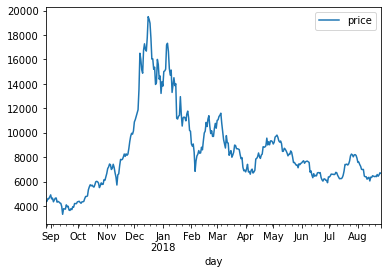

,price
day,
2017-08-27,4354.308333
2017-08-28,4391.673517
2017-08-29,4607.985450
2017-08-30,4594.987850
2017-08-31,4748.255000
...,...
2018-08-22,6575.229167
2018-08-23,6434.881667
2018-08-24,6543.645714


In [2]:
# 시계열 정보를 데이터 프레임의 index로 설정하여 가격의 추이를 시각화

# to_datetime으로 day 피처를 시계열 피처로 변환
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day 데이터 프레임의 index로 설정
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

# 일자별 비트코인 시세를 시각화
bitcoin_df.plot()
plt.show()
bitcoin_df

## step 2 예측 : 파이썬 라이브러리를 활용해 시세 예측하기
- **ARIMA** 분석 방법   
전통적인 시계열 예측 방법으로 두가지 개념을 포함하고 있음
    - AR 모델로 자기 자신의 과거를 정보로 사용   
    '현재의 상태는 이전의 상태를 참고해서 계산된다'
    - MA 모델로 '이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다'
    - 이 둘을 합친 것이 **ARMA** 모델
    - **ARIMA** 모델은 ARMA 모델에 추세 변동의 경향성까지 반영   
    
- 파이썬에서는 statsmodel 모듈로 ARIMA 분석을 수행할 수 있음
- ARIMA 클래스에 order(2,1,2)는 'AR이 몇번째 과거까지를 바라보는지에 대한 파라미터(2), 차분에 대한 파라미터(1), MA가 몇번째 과거까지를 바라보는지에 대한 파라미터(2)'를 의미
- 차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것. 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할

In [3]:
! conda install statsmodels==0.12.2

Solving environment: ...working... done

# All requested packages already installed.



In [11]:
# # ARIMA 모델 활용하기 : 모델학습
# # from statsmodels.tsa.arima_model import ARIMA
# # from statsmodels.tsa.arima.model import ARIMA
# import statsmodels.api as sm

# # (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
# # model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
# model = sm.tsa.arima.ARIMA(bitcoin_df.price.values, order=(2,1,2))
# model_fit = model.fit()
# # model_fit = model.fit(trend='c', full_output=True, disp=True)
# print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.490
Date:                Wed, 27 Apr 2022   AIC                           5584.980
Time:                        16:15:15   BIC                           5604.466
Sample:                             0   HQIC                          5592.725
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2418      0.305      0.794      0.427      -0.355       0.839
ar.L2          0.6072      0.200      3.038      0.002       0.215       0.999
ma.L1         -0.1513      0.306     -0.495      0.6

In [4]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Fri, 29 Apr 2022   AIC                           5587.107
Time:                        15:51:54   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3675     27.794      0.229      0.819     -48.108      60.843
ar.L1.D.y     -0.3790      1.830     -0.207      0.836      -3.965       3.207
ar.L2.D.y      0.1584      1.192      0.133      0.8

- 상수항을 제외한 모든 계수의 p-value가 0.05 이하로 유의미함
- AR과 MA 모두 2로 설정하는 것이 의미있는 분석 결과 도출했다는 것

<AxesSubplot:>

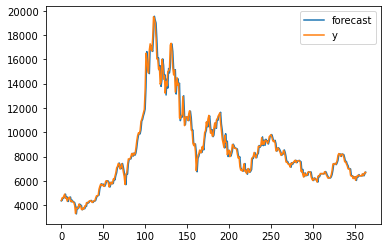

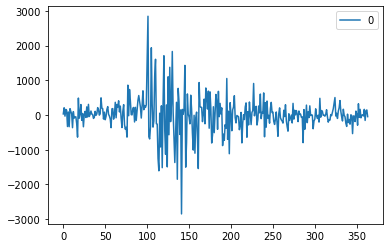

In [5]:
fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)
residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

- 두번째 그래프는 실제값과 예측값 사이의 오차 변동을 나타내는 그래프   
이 그래프의 폭이 일정하다면 좋은 예측 모델을 학습시킨 것  
하지만 실행 결과에서 오차 변동이 매우 불안정함
- 모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데, 이번 예제에서는 5일 동안의 미래를 테스트 데이터로 사용  
불규칙적 시계열 예측의 경우에는 먼 미래를 예측하는 것이 큰 의미가 없으므로 '앞으로 N일 동안 어느정도로 상승/하락할 것이다' 정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문

모델 평가의 과정
1. model_fit.forecast(steps = 5)로 향후 5일의 가격을 예측하여 pred_y로 정의
2. '../data/market-price-test.csv'에서 실제 향후 5일의 가격을 test_y로 정의
3. 모델이 예측한 상한값, 하한값을 pred_y_upper, pred_y_lower로 정의
4. 정의한 모든 값을 비교하여 5일 동안의 상승 경향 예측이 얼마나 맞았는지를 평가

In [6]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = '../data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

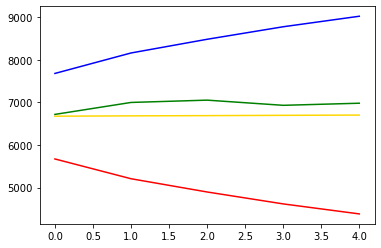

In [7]:
# 이를 그래프로 시각화
# 파란색 그래프는 모델이 예상한 최고 가격, 상한가 그래프
# 빨간색은 모델이 예측한 하한가 그래프
# 초록색은 실제 5일간의 가격 그래프
# 노란색은 모델이 예측한 5일간의 가격 그래프
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

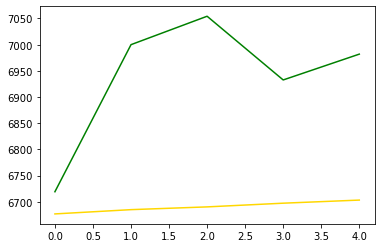

In [8]:
# 이번에는 상한가와 하한가를 제외한 뒤, 그래프를 살펴보기
# 그래프의 상승 경향을 살펴보면 좋지 않은 예측을 한 것으로 보임
# '5일 동안 상승화할 것이다.'라는 아주 큰 트렌드 정도는 예측할 수 있음
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green") # 실제 가격 그래프

- fbprophet라이브러리를 사용하기 위해서는 데이터 프레임의 피처를 'ds'와 'y'로 변경
- Prophet 이라는 클래스를 선언한 뒤, fit() 함수로 모델을 학습
- 모델 생성에 포함되는 파라미터
    * seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미
    * changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영. 수치가 높을수록 모델은 과적합에 가까워짐

In [9]:
! conda install -c conda-forge fbprophet

^C


In [11]:
from fbprophet import Prophet

# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경: 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

make_future_dataframe(periods = 5, freq='d'), prophet.predict(future_data)를 실행하면 학습 데이터셋 기반의 5일 단위 예측 데이터를 얻을 수 있음   
아래의 실행 결과는 데이터에 존재하지 않는 5일 단위의 미래를 예측한것

In [12]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [13]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
365,2018-08-27,798.936686,6242.666917,7561.414435,798.936686,798.936686,8.968437,8.968437,8.968437,7.636134,...,-0.006461,-0.006461,-0.006461,-1.325842,-1.325842,-1.325842,0.0,0.0,0.0,6899.724550
366,2018-08-28,803.275432,6310.698912,7679.349461,803.275432,803.275432,8.968437,8.968437,8.968437,7.701947,...,0.017381,0.017381,0.017381,-1.283871,-1.283871,-1.283871,0.0,0.0,0.0,6990.060163
367,2018-08-29,807.614178,6321.385290,7679.686837,807.614178,807.614178,8.968437,8.968437,8.968437,7.668899,...,-0.042695,-0.042695,-0.042695,-1.256844,-1.256844,-1.256844,0.0,0.0,0.0,7001.125569
368,2018-08-30,811.952923,6381.600780,7741.574442,807.377628,811.952923,8.968437,8.968437,8.968437,7.707693,...,-0.013228,-0.013228,-0.013228,-1.247516,-1.247516,-1.247516,0.0,0.0,0.0,7070.236574
369,2018-08-31,816.291669,6383.610439,7892.093435,803.549754,818.131499,8.968437,8.968437,8.968437,7.744832,...,0.034494,0.034494,0.034494,-1.258099,-1.258099,-1.258099,0.0,0.0,0.0,7138.333532


fbprophet 모델의 학습 결과 시각화   

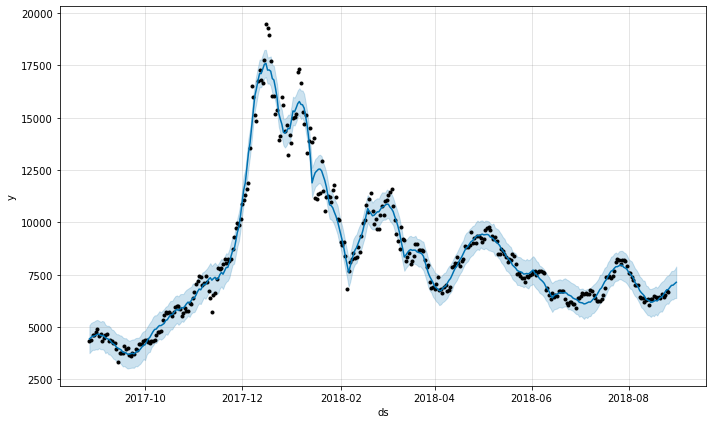

In [14]:
fig1 = prophet.plot(forecast_data)

그래프의 검은 점은 실제 가격  
파란 선은 예측 가격   
ARIMA 모델과 마찬가지로 학습 데이터셋에 대해서는 거의 정확한 예측   
하지만 시계열 데이터 분석에서 학습 데이터를 잘 예측하는 것은 큰 의미가 없음

fbprophet에서 제공하는 트렌드 정보 시각화 그래프   
seasonality_mode 파라미터를 설정해놓은 경우에만 시각화 가능   

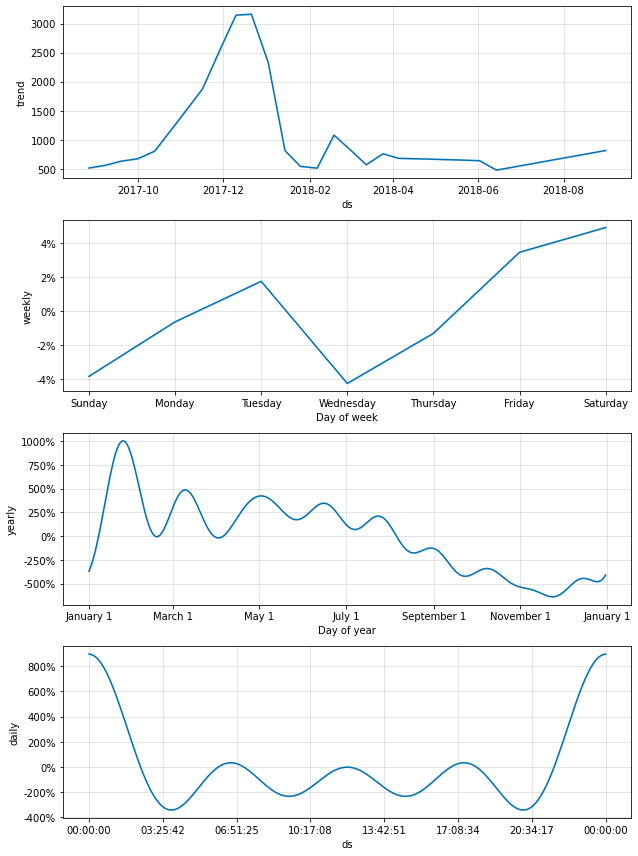

In [15]:
fig2 = prophet.plot_components(forecast_data)

- year, weekly, daily 순의 트렌드 확인 가능

모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산

In [16]:
# 실제 데이터와의 비교

 # 첫 5일을 제외한 실제 가격 데이터
y = bitcoin_df.y.values[5:]
# 첫 5일, 마지막 5일을 제외한 예측 가격 데이터()
y_pred = forecast_data.yhat.values[5:-5] 

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

522.9914013338496
0.9737081852904241


ARIMA 모델을 평가한 것과 동일한 방법으로 테스트 데이터셋을 평가   

ARIMA 모델보다는 prophet 모델이 실제 price값에 더 근접한 예측을 하는 것처럼 보임   

In [29]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

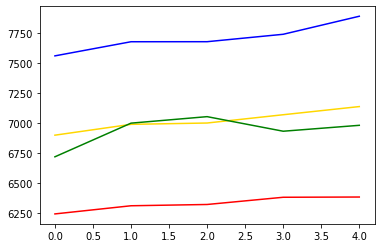

In [30]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

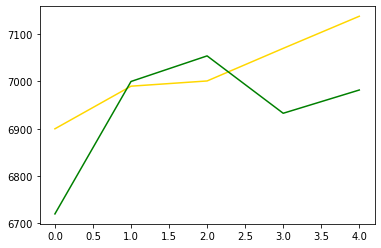

In [31]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [32]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

125.59735772191783


## step 3 활용 : 더 나은 결과를 위한 방법
[상한값 혹은 하한값 지정]
- 주가 데이터의 경우에는 바닥과 천장이 없어서 의미가 없지만, 일반적인 시계열 데이터에서는 상한값 혹은 하한값을 설정해주는 것이 모델의 성능을 높여줄 수 있는 방법 중 하나
- prophet 모델에서는 future_data['cap'] = 20,000을 통해 데이터셋에 상한선을 설정할 수 있음

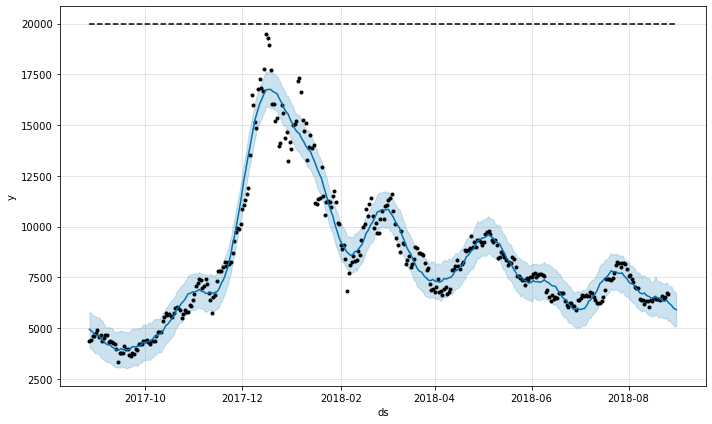

In [33]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

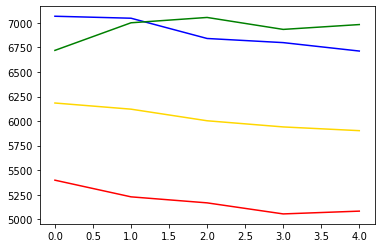

In [34]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

- 비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.

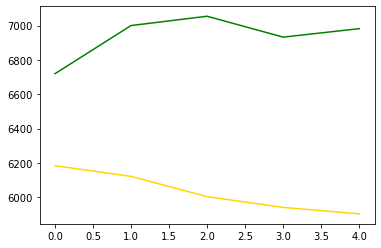

In [35]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

[이상치 제거 기법]
- 이상치 : 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터
- 상자 그림의 울타리 밖 영역에 있는 데이터
- fbprophet 모델이 이상치를 제거한 데이터로 학습하려면 이상치에 해당하는 데이터를 None으로 설정해주면 됨
- 18,000이상을 이상치라고 설정

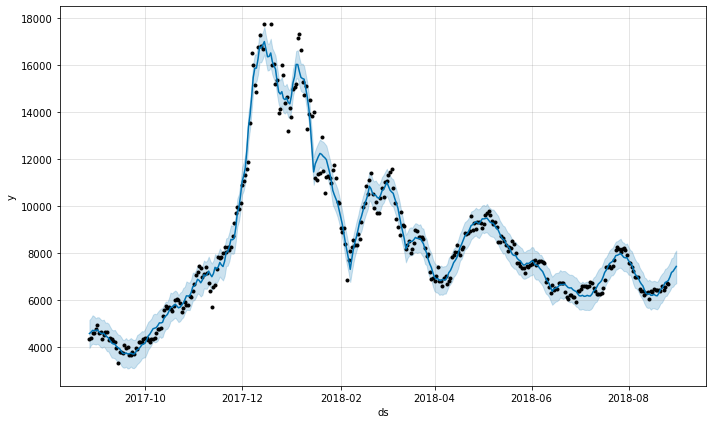

In [38]:
# 가격이 18000을 넘어가는 값을 이상치로 판단하여 제거
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

예측값과 실제값을 그래프로 나타내기

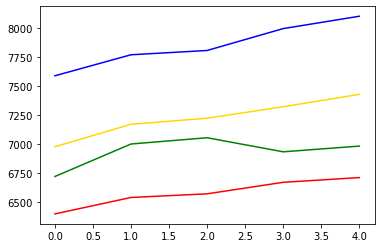

In [39]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

308.19506587310275


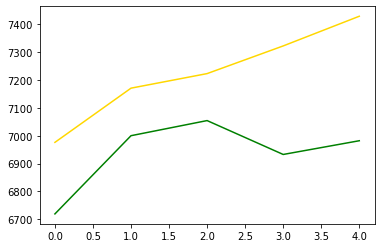

In [41]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

- 비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.
- 모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있습니다.

# 미래에 볼 영화의 평점 예측하기
## step 1 탐색 : MovieLens 데이터 살펴보기
- MovieLens 데이터는 총 3개의 데이터셋으로 분리되어 있으며 데이터셋을 구성하는 피처는 아래와 같다
    * rating 데이터
        + user_id(유저번호)
        + movie_id(영화번호)
        + rating(점수)
        + time(데이터 등록 시간)
    * movie 데이터
        + movie_id(영화 번호)
        + title(영화 제목)
        + genre(장르)
    * user 데이터
        + user_id(유저 번호)
        + gender(성별)
        + age(나이)
        + occupation(직업-개인정보1)
        + zipcode(주소코드-개인정보2)

- 각 데이터는 '::' 구분자로 열을 구분하였기 때문에 read_csv()함수를 사용할 때 delimiter='::' 파라미터를 포함해야 함

In [2]:
# 3개의 데이터 (rating_data, movie_data, user_data)를 각각 head()함수로 살펴본 결과
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

rating_file_path = "../data/ml-1m/ratings.dat"
movie_file_path = "../data/ml-1m/movies.dat"
user_file_path = "../data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::')
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


## step 2 분석 : 탐색적 데이터 분석하기
- 영화의 개수와 연도별 탐색에 대한 출력 결과
- 영화의 개수는 약 4,000여 개 정도
- 1990년대 후반부터 2000년대 초반의 영화가 가장 많음
- 영화의 연도 정보는 movie_data['title'].apply(lambda x:x[-5:-1]) 코드를 통해 추출한 것으로 영화의 제목 뒤에 따라붙는 연도 정보를 이용

In [6]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

미니퀴즈 3-3
영화의 연대별 개수

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


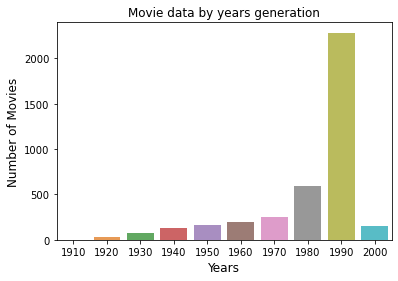

In [7]:
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

가장 많이 등장한 장르가 무엇인지 탐색
- movie_data의 피처인 genre는 '드라마|코미디|액션'처럼 '|'이라는 구분자를 포함하여 여러 장르를 하나의 문자열에 포함
- 데이터에 등장하는 모든 개별 장르를 세기 위해서 split()함수로 genre 데이터를 분리
- 각 장르마다의 등장 개수는 dictionary 자료로 저장

In [8]:
# 가장 많이 사용된 장르의 조합을 출력합니다. (Top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


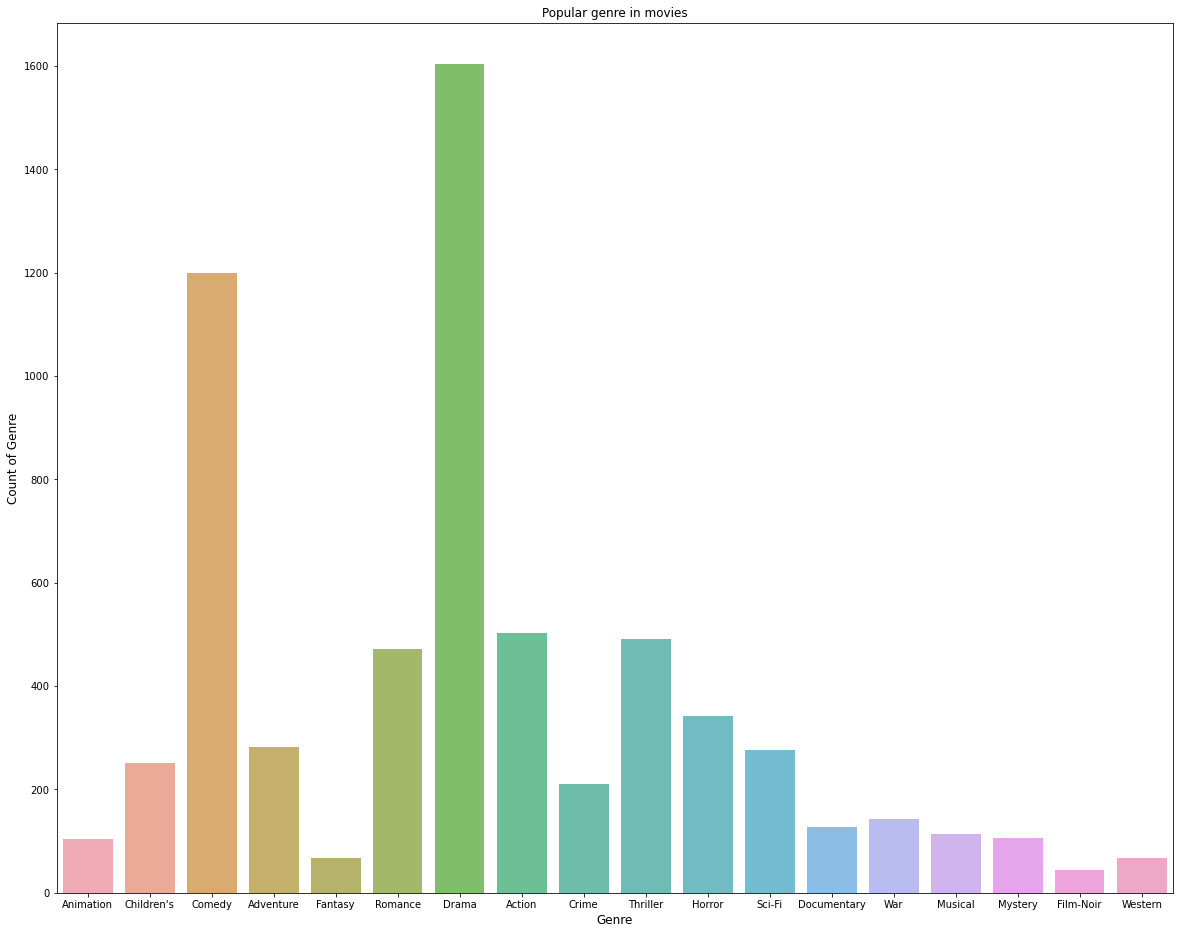

In [9]:
# 가장 많이 등장한 장르의 속성을 추출합니다. (예시 : Drama)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

In [10]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


미니퀴즈 3-4 유저
- 유저의 성별 탐색
- 유저의 연령대 탐색

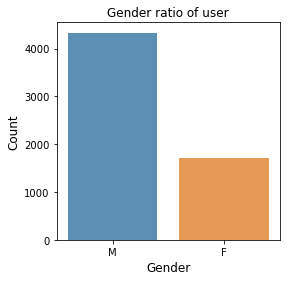

In [11]:
# 유저의 성별 탐색 
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [12]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [13]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

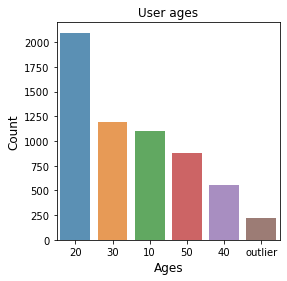

In [14]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

각 영화가 얼마나 많은 평가를 받았는지 탐색

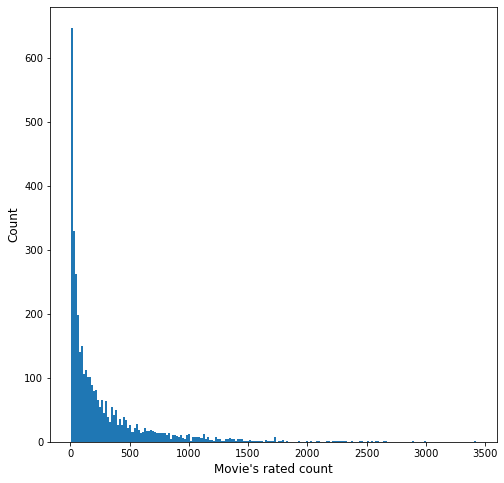

In [15]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

- 'movie_id' 기준으로 groupby()한뒤, 'rating'에 count()함수를 적용
- x축은 각 영화가 평가받은 횟수
- y축은 각 영화가 평가받은 횟수

In [16]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [17]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

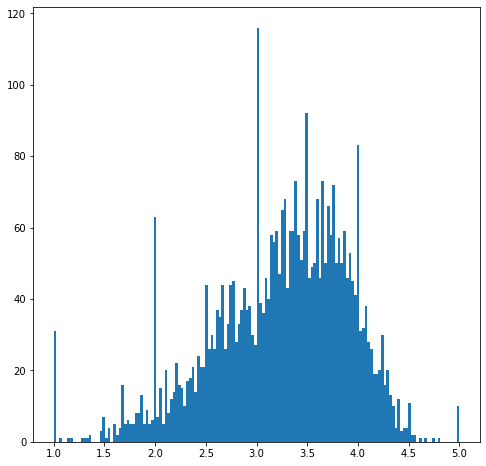

In [18]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

미니 퀴즈 3-5
- 유저별로 평가한 영화 개수
- 유저별로 평가한 평균 영화 점수
- 유버별로 평가한 영화 점수의 편차

In [19]:
# 유저별 영화 평가를 탐색합니다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


<AxesSubplot:>

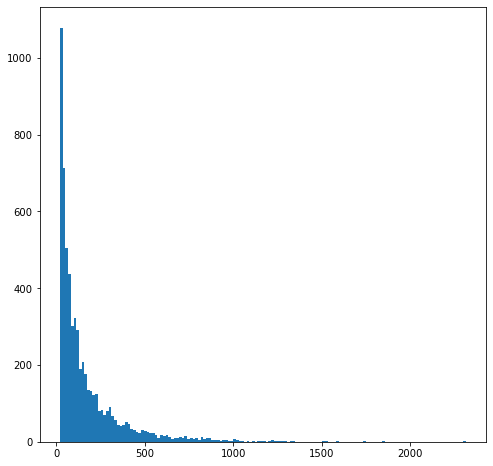

In [20]:
# 유저별로 평가한 영화 개수의 분포를 출력합니다.
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

<AxesSubplot:>

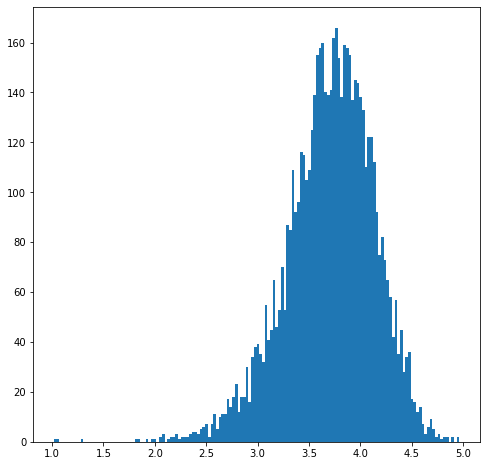

In [21]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

<AxesSubplot:>

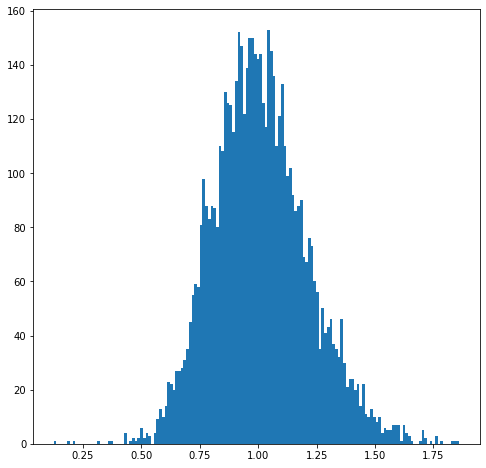

In [22]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

MovieLens 데이터는 U-I-R(User-Item-Rating) 데이터셋
- 이러한 데이터는 **행렬**로 나타내기에 매우 용이
- 행과 열은 각각 user와 movie를 의미, 점을 표현하는 컬러는 Rating 값을 의미

In [23]:
#user-movie 형태의 표로 살펴보기
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [24]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

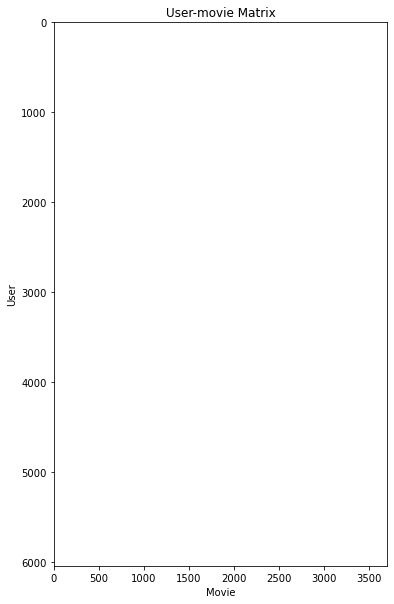

In [25]:
# user-movie 테이블을 시각화합니다.
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

- 대부분의 공간에 색이 없는 행렬(희소 행렬). 대부분의 Rating 점수가 아직 채워지지 않았다는 것을 의미
- 비어있는 Rating을 채워넣을 수 있는 가장 대표적인 방법은 행렬의 빈 공간을 채우는 **행렬 완성(Matrix Completion)** 기법

## step 3 예측 : 수학적 기법을 활용해 평점 예측하기
행렬 완성은 **행렬 분해**방법을 이용   

행렬 분해는 수학적 성질을 이용하여 하나의 행렬을 여러 개의 행렬 곱으로 나타내는 방법

특이값 분해(SVD) : m x n 행렬 A를 3개의 행렬 U, S, V로 나누는 것   

행렬 완성의 과정
1. 3개로 나눠진 행렬 U,S,V의 값을 임의의 숫자로 초기화. "?"로 표현한 부분
2. 임의의 값으로 채워진 3개 행렬을 곱하여 새로운 행렬 A'를 계산
3. 새롭게 만들어진 행렬 A'의 값, 원래의 행렬 A의 값을 비교
4. 이 값들이 최대한 비슷해지는 "?"를 학습한 뒤, 행렬 A' 빈공간을 채워넣는다.

평점의 범위가 1~5인 Reader 객체를 생성   
load_from_df()함수와 build_full_trainset()함수를 이용하여 rating 데이터를 surprise 라이브러리의 데이터셋 형태로 변환해줌   
SVD라는 클래스 선언한뒤, model.fit(train_data)로 행렬 완성 모델을 학습   

In [26]:
# 빈칸을 포함한 user-item 행렬 생성
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [27]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

In [28]:
# SVD 사용을 위한 데이터셋을 생성합니다.
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

In [29]:
# SVD 모델을 학습합니다.
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

In [30]:
# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

Item id 1 | predicted rating : 3.6102654697356207
Item id 3 | predicted rating : 3.8048326194150466


In [31]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.5028130770912718
Item id 2 | real rating : 4.0 | predicted rating : 3.83705579509734
Item id 3 | real rating : 4.0 | predicted rating : 3.7265658732161104
Item id 1 | real rating : 2.0 | predicted rating : 3.502648033041741
Item id 2 | real rating : 5.0 | predicted rating : 3.8450571429163847
Item id 3 | real rating : 4.0 | predicted rating : 3.74084217219592
Item id 2 | real rating : 5.0 | predicted rating : 3.914328057592053


In [32]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 104.96 seconds


영화의 점수를 예측할 타겟 유저 선정

In [33]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [34]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개 선정

In [35]:
# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [36]:
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)
# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]
# 예측된 Top 10 영화
target_user_top10_predicted

[(111, 5),
 (116, 5),
 (318, 5),
 (326, 5),
 (527, 5),
 (567, 5),
 (593, 5),
 (602, 5),
 (608, 5),
 (615, 5)]

Top 10 영화의 제목을 매칭하여 출력

In [37]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Taxi Driver (1976) : 5
Anne Frank Remembered (1995) : 5
Shawshank Redemption, The (1994) : 5
To Live (Huozhe) (1994) : 5
Schindler's List (1993) : 5
Kika (1993) : 5
Silence of the Lambs, The (1991) : 5
Great Day in Harlem, A (1994) : 5
Fargo (1996) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5


In [38]:
# 타겟 유저의 기존 선호 영화와 비교합니다.
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


## step4 평가 : 예측 모델 평가하기
예측이 얼마나 정확한 예측인지 알기 위해서는 모델이 얼마나 정확하게 행렬을 완성했는지 평가해야함  

행렬 완성의 가장 보편적인 평가 방법은 RMSE를 계산하는 것

데이터를 학습 데이터셋과 테스트 데이터셋으로 분리한 뒤, 학습 데이터셋을 사용하여 SVD모델을 학습   

테스트 데이터로 predictions라는 예측값을 생성하여 RMSE를 계산

In [39]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 101.63 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8628


0.862754108880095

미니퀴즈 3-6   
- RMSE를 이용해 적당한 하이퍼 파라미터 n_factors를 찾자
- 하이퍼 파라미터 n_factors 설정 변화에 따른 RMSE 그래프를 출력해라

In [40]:
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(1, 15):    
    train_start = time.time()
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 81.17 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8855
------------------------------------
training time of model: 81.54 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8762
------------------------------------
training time of model: 86.67 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8730
------------------------------------
training time of model: 88.20 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8656
------------------------------------
training time of model: 101.51 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8668
------------------------------------
training time of model: 114.30 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8625
------------------------------------
training time of model: 115.31 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8615
------------------------------------
training time of model: 115.19 seconds
RMSE of test 

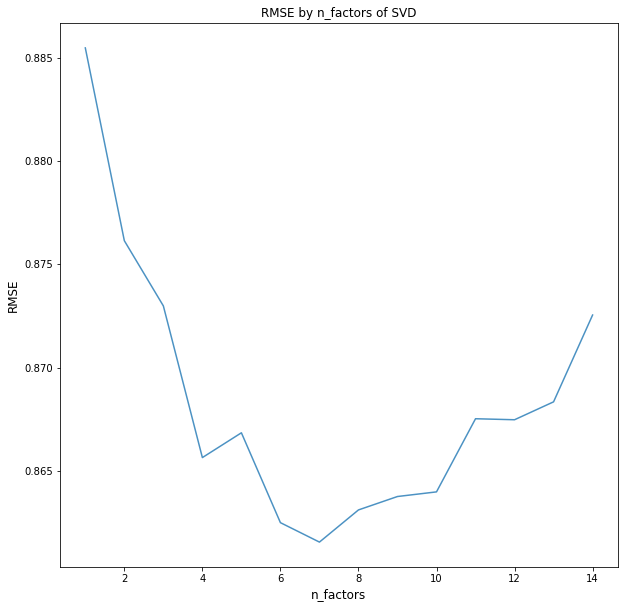

In [41]:
plt.plot(range(1, 15), rmse_list_by_factors, alpha=0.8)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

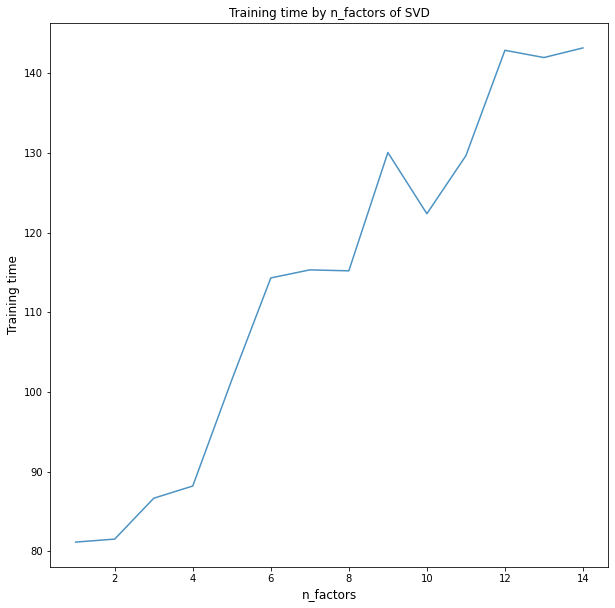

In [42]:
plt.plot(range(1, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

4번 유저의 예측 평점과 실제 평점을 비교하는 시각화 그래프  

4번 유저가 영화를 아직 보지 않았다는 가정하에 실제로 보았던 21개 영화의 가상 예측 평점 계산

In [43]:
# 실제 평점과의 비교 시각화하기 : 평점 예측 단계
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))
        
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)
target_user_movie_predict_dict

{260: 3.8781255758849786,
 480: 3.1285116536151882,
 1036: 4.055410845412515,
 1097: 4.5189098863589825,
 1196: 3.5290241595997154,
 1198: 4.437181252147182,
 1201: 4.452952080087919,
 1210: 3.054902644004989,
 1214: 4.057579019014238,
 1240: 3.8301457752313737,
 1387: 4.439154156836766,
 1954: 4.626387673281691,
 2028: 4.697443581986514,
 2366: 3.9201173501831956,
 2692: 3.9696712204292233,
 2947: 4.409394243957542,
 2951: 4.339517895070068,
 3418: 4.458883457173255,
 3468: 4.824828007619624,
 3527: 3.1224717657189665,
 3702: 4.0772882140157956}

In [44]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 3.88
movie 2 : Jurassic Park (1993) - 4 / 3.13
movie 3 : Die Hard (1988) - 4 / 4.06
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.52
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.53
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.44
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.45
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.05
movie 9 : Alien (1979) - 4 / 4.06
movie 10 : Terminator, The (1984) - 5 / 3.83
movie 11 : Jaws (1975) - 5 / 4.44
movie 12 : Rocky (1976) - 5 / 4.63
movie 13 : Saving Private Ryan (1998) - 5 / 4.7
movie 14 : King Kong (1933) - 4 / 3.92
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 3.97
movie 16 : Goldfinger (1964) - 5 / 4.41
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.34
movie 18 : Thelma & Louise (1991) - 4 / 4.46
movie 19 : Hustler, The (1961) - 5 / 4.82
movie 20 : Predator (1987) - 1 / 3.12
movie 21 : Mad Max (1979) - 4 / 4.08


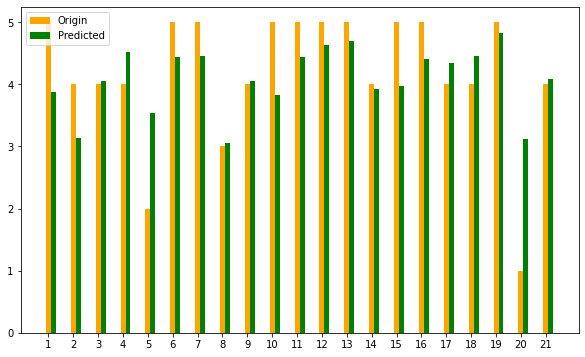

In [45]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

연습문제

In [46]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Data Source : http://lib.stat.cmu.edu/datasets/boston_corrected.txt

file_path = '../data/BostonHousing2.csv'
housing = pd.read_csv(file_path)
housing = housing.rename(columns={'CMEDV': 'y'})
housing.head()

,TOWN,LON,LAT,y,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


BostonHousing 데이터셋으로 회귀분석을 수행하기 위한 데이터셋을 분리

In [47]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습, 테스트 데이터셋 데이터를 생성합니다.
X = housing[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
             'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = housing['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

분리한 데이터셋으로 회귀분석 수행

In [48]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

학습 완료된 모델의 R2 score 평가

In [49]:
# R2 score를 출력합니다.
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7490284664199387
0.7009342135321543


회귀모델 피처의 계수 출력

In [50]:
# 각 피처의 계수를 출력합니다.
print(lr.coef_)

[ -0.11119355   0.05094152   0.03254362   3.02115825 -15.41085562
   4.0459089   -0.00197595  -1.56114408   0.32703872  -0.01388252
  -0.82215163   0.00874659  -0.58506026]
